# Simulating flows

In this recitation, we will work towards a better understanding about how to simulating the movement of particles on a discrete flow field. In particular, this will be helpful for the section project where you will be asked to use simulation of particle movement on oceanic data presented in the form of discrete flow fields.

- **Disclaimer 1:** This is by no means, a comprehensive study of computational fluid dynamics. To the interested reader please see: Stam, Jos. **"Stable fluids."** in the *Proceedings of the 26th Annual Conference on Computer graphics and Interactive Techniques 1999*. Another great source for fluid simulations can be found in https://www.karlsims.com/flow.html
- **Disclaimer 2:** In this recitation, we will work only on 2-dimensional spaces. However, the techinques and procedues can be extended to other spaces.
- **Disclaimer 3:** We will initially focus on the movement of a single particle. For simulating multiple non-interacting particles the process scales similarly. We do not consider interacting particles.

## What is a flow?
A flow refers to displacement in time, that is if $x(t)$ denotes the location of a particle at time $t$. Then, we define the flow vector as
\begin{equation}
 \frac{d x(t)}{dt}= V(x(t),t).
\end{equation}
or similarly, their explicit Euler discretization as, for a small $\varepsilon > 0$ , then
\begin{equation}
  x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t).
\end{equation}

Informally, if we know the position of a particle at time $t$, then, after some arbitrarily small time $\varepsilon$, that is, at time $t+\varepsilon$, we can compute the new position $x(t+\varepsilon)$ as $x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t)$, assuming we know the flow information coded in the function $V(x(t),t)$.

The next figure shows a simple flow system with four points, shown as white circles. Each point corresponds to a physical location also shown in kilometers. Attached to each point is a flow data point, which is shown as a blue arrow. Recall that flow data is given in the $x$ and $y$ direction. It is assumed that a particle moving in one of the zones or boxes acquires the velocity given by the flow data.

## Example 1: A particle on a constant flow field.

In this example, we are going to simulate the movement of a single particle in a box with unit length. Moreover, we are going to assume the velocity information or the flow data is constant on this box. You will be able to set the maximum time of the simulation, the number of steps, the initial position of the particle. and the velocity of the flow in the $x$ and $y$ axis.

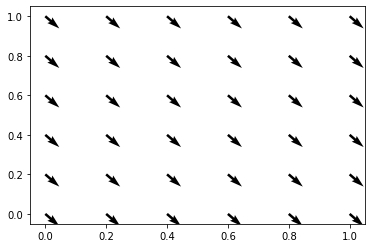

In [4]:
import numpy as np
import matplotlib.pyplot as plt


T = 4.0 #@param {type:"number"}
N = 50 #@param {type:"integer"}
epsilon = T/N

x_0 = np.random.rand(2)
v = 0.5 * np.random.rand(2) - 0.25

g_x, g_y = np.meshgrid(np.arange(0, 1.1, 0.2), np.arange(0, 1.1, 0.2))
w_x, w_y = np.ones(g_x.shape)[None, :, :] * v[:, None, None]
qv = plt.gca().quiver(g_x, g_y, w_x, w_y)

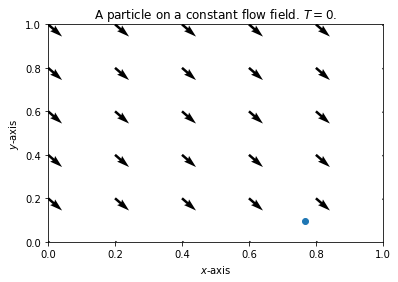

In [5]:
import matplotlib.pyplot as plt

def flowplot(ax, loc, grid_x, grid_y, fl_x, fl_y, title, overlay=None):
  sc = ax.scatter(loc[0], loc[1], marker='o')
  ax.set_xlabel(r"$x$-axis")
  ax.set_ylabel(r"$y$-axis")
  ax.axis([0, 1, 0, 1])
  ax.set_title(title)
  qv = ax.quiver(grid_x, grid_y, fl_x, fl_y)
  if overlay:
    overlay(ax)
  def update(new_loc, new_fl = None, new_title=None):
    sc.set_offsets(new_loc)
    if new_title:
      ax.set_title(new_title)
    if new_fl:
      qv.set_UVC(*new_fl)
      return sc, qv
    else:
      return sc,
  return update

flowplot(plt.gca(), x_0, g_x, g_y, w_x, w_y, r"A particle on a constant flow field. $T = 0$.")
plt.show()

In [6]:
xs = [(x_0, 0)]
t = 0
for _ in range(N):
  x = xs[-1][0] + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  # Safety stop if particle goes out of bounds.
  if np.any(np.logical_or(x > 1, x < 0)):
    break

  xs.append((x,t))

import matplotlib.animation as anim
from matplotlib import rc
rc('animation', html='jshtml')

fig, ax = plt.subplots()
update_plot = flowplot(ax, x_0, g_x, g_y, w_x, w_y, r"A particle on a constant flow field2. $T = 0$.")

def frame(x):
  return update_plot(x[0], new_title=r"A particle on a constant flow field2. $T = {:.2f}$.".format(x[1]))

animation = anim.FuncAnimation(fig, frame, frames=xs, blit=True)
plt.close()

In [7]:
animation

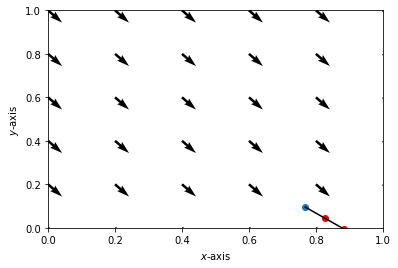

In [8]:
ax = plt.gca()
ax.set_xlabel(r"$x$-axis")
ax.set_ylabel(r"$y$-axis")
ax.axis([0, 1, 0, 1])
qv = ax.quiver(g_x, g_y, w_x, w_y)
plt.plot(x_0[0],x_0[1], 'o')

def nearest_index(x, g_x, g_y, num_vals = 1):
  flat_g_x = g_x.flatten()
  flat_g_y = g_y.flatten()
  distances = np.array([np.abs(x[0] - flat_g_x[idx]) + np.abs(x[1] - flat_g_y[idx]) for idx in np.arange(len(flat_g_x))])
  sorted_index = distances.argsort()
  return sorted_index[0:num_vals]

def iterate_nearest_match(x, epsilon, flow_x, flow_y, g_x, g_y):
  assert(flow_x.shape == flow_y.shape)
  assert(flow_x.shape == g_x.shape)
  assert(g_y.shape == g_x.shape)
  flow_x = flow_x.flatten() # easier to work with 1-D indexes in python 
  flow_y = flow_y.flatten() 
  v = np.array([flow_x[nearest_index(x, g_x, g_y)], flow_y[nearest_index(x, g_x, g_y)]]).reshape(x.shape)
  return x + v * epsilon
old_x = x_0
n_iterations = 100
for _ in range(n_iterations):
  new_x = iterate_nearest_match(old_x, 3 * epsilon, w_x, w_y, g_x, g_y)
  plt.plot(new_x[0],new_x[1],'ro')
  plt.plot([old_x[0], new_x[0]],[old_x[1],new_x[1]], 'k');
  old_x = new_x

## Example 2: A particle on an oscillating field

As a second example, we will assume that the velocities of the flow in the $x$ and $y$ axis follow an oscillating behaviour, with certain frequency.

In [9]:
f = 1.5 #@param {type:"slider", min:0.5, max:10, step:0.5}
T = 2.0 #@param {type:"number"}
N = 100 #@param {type:"integer"}
epsilon = T/N

x_0 = np.random.rand(2)
t = np.arange(0, T, epsilon) # Create the vector of times
v_x = np.sin(2*np.pi*f*t) # Compute the velocity values at every time instant
v_y = np.cos(2*np.pi*f*t) # Compute the velocity values at every time instant

# Plot the velocities
plt.subplot(211)
plt.plot(t,v_x)
plt.xlabel('time')
plt.ylabel('x-axis velocity')
plt.title('Velocity in the x-axis')
plt.subplot(212)
plt.plot(t,v_y)
plt.xlabel('time')
plt.ylabel('x-axis velocity')
plt.title('Velocity in the x-axis')
plt.show()

# Create a Mesh for showing the flow data
g_x, g_y = np.meshgrid(np.arange(0, 1.1, 0.2),np.arange(0, 1.1, 0.2))
v_0 = np.array([v_x[0], v_y[0]])
w_x, w_y = np.ones(g_x.shape)[None, :, :] * v_0[:, None, None]

flowplot(plt.gca(), x_0, g_x, g_y, w_x, w_y, r"A particle on an oscillating flow field. $T = 0$.")
plt.show()

state = [(x_0, 0, v_0, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time

  # Safety stop if particle goes out of bounds.
  if np.any(np.logical_or(x > 1, x < 0)):
    break

  v = np.array([v_x[i], v_y[i]])
  state.append(
      (x, t, v)
      + tuple(np.ones(g_x.shape)[None, :, :] * v[:, None, None])
      )
  
def animate(state, g_x, g_y, title, overlay=None):
  fig, ax = plt.subplots()
  x_0, t_0, v_0, fl_x, fl_y = state[0]
  update_plot = flowplot(ax, x_0, 
                         g_x, g_y, 
                         fl_x, fl_y, 
                         title.format(t_0),
                         overlay)

  def frame(s):
    x, t, v, fl_x, fl_y = s
    return update_plot(x,
                      new_fl = (fl_x, fl_y), 
                      new_title=title.format(t))

  animation = anim.FuncAnimation(fig, frame, frames=state, blit=True)
  plt.close()
  return animation
animate(state, g_x, g_y, r"A particle on an oscillating flow field. $T = {:.2f}$.")

Output hidden; open in https://colab.research.google.com to view.

## Velocity Varies across Space

In this exercise, the flow is a function of space. We therefore need to consider ways to interpolate between observations of the flow. 

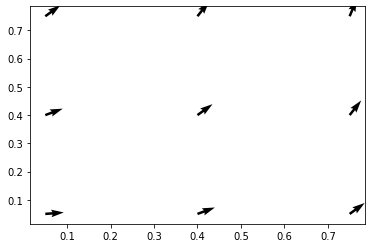

In [ ]:
# This code generates a simple vector field that varies over space
g_x, g_y = np.meshgrid(np.arange(0.05, 1, 0.35),np.arange(0.05, 1, 0.35))
w_x = np.cos((g_x + g_y) * np.pi / 4)
w_y = np.sin((g_x + g_y) * np.pi / 4)

plt.quiver(g_x, g_y, w_x, w_y)
plt.show()

In [ ]:
# Helper functions - fill in missing methods 
def nearest_index(x, g_x, g_y, num_vals = 1):
  flat_g_x = g_x.flatten()
  flat_g_y = g_y.flatten()
  distances = np.array([np.abs(x[0] - flat_g_x[idx]) + np.abs(x[1] - flat_g_y[idx]) for idx in np.arange(len(flat_g_x))])
  sorted_index = distances.argsort()
  return sorted_index[0:num_vals]

def iterate_nearest_match(x, epsilon, flow_x, flow_y, g_x, g_y):
  assert(flow_x.shape == flow_y.shape)
  assert(flow_x.shape == g_x.shape)
  assert(g_y.shape == g_x.shape)
  flow_x = flow_x.flatten() # easier to work with 1-D indexes in python 
  flow_y = flow_y.flatten() 
  index_match = nearest_index(x, g_x, g_y)
  v = np.array([flow_x[index_match], flow_y[index_match]]).reshape(x.shape)
  return x + v * epsilon

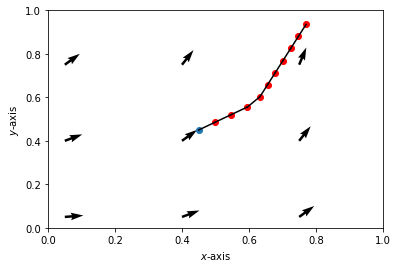

In [ ]:
ax = plt.gca()
ax.set_xlabel(r"$x$-axis")
ax.set_ylabel(r"$y$-axis")
ax.axis([0, 1, 0, 1])
qv = ax.quiver(g_x, g_y, w_x, w_y)
x0 = 0.45 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
x1 = 0.45 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

old_x = np.array([x0, x1])
plt.plot(old_x[0],old_x[1], 'o')
n_iterations = 10
for _ in range(n_iterations):
  new_x = iterate_nearest_match(old_x, 3* epsilon, w_x, w_y, g_x, g_y)
  plt.plot(new_x[0],new_x[1],'ro')
  plt.plot([old_x[0], new_x[0]],[old_x[1],new_x[1]], 'k');
  old_x = new_x

## Now, use Gaussian Processes to interpolate between grid points

In [ ]:
# TODO: add code to implement gaussian processes for interpolating flow 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel as C, DotProduct
l = 1
kernel = RBF(l) 
XY = np.array([(g_x.flatten()[idx], g_y.flatten()[idx]) for idx in np.arange(len(g_x.flatten()))])
gpr_x = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr_x.fit(XY, w_x.flatten())
gpr_y = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr_y.fit(XY, w_y.flatten())

def iterate_Gaussian(x, epsilon, gpr_x, gpr_y):
  v = np.array([gpr_x.predict(x.reshape(-1,2)),
               gpr_y.predict(x.reshape(-1,2))]).reshape(x.shape)
  return x + v * epsilon

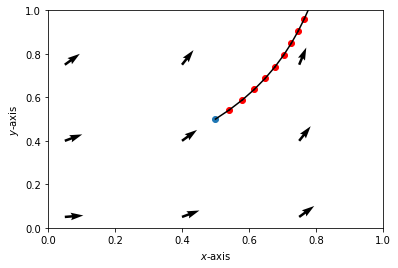

In [ ]:
ax = plt.gca()
ax.set_xlabel(r"$x$-axis")
ax.set_ylabel(r"$y$-axis")
ax.axis([0, 1, 0, 1])
qv = ax.quiver(g_x, g_y, w_x, w_y)
x0 = 0.5 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
x1 = 0.5 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

old_x = np.array([x0, x1]).reshape(-1,1)
plt.plot(old_x[0],old_x[1], 'o')
n_iterations = 10
for _ in range(n_iterations):
  new_x = iterate_Gaussian(old_x, 3 * epsilon, gpr_x, gpr_y)
  plt.plot(new_x[0],new_x[1],'ro')
  plt.plot([old_x[0], new_x[0]],[old_x[1],new_x[1]], 'k');
  old_x = new_x

## Flows vary with Time and Space

Now, we look at a natural extension, considering a flow that varies in time and space, and simulating multiple independent particles. 

In [ ]:
T = 2.0 #@param {type:"number"}
N = 200 #@param {type:"integer"}
num = 30 #@param {type:"integer"}
m = 20 #@param {type:"slider", min:0, max:20, step:1}
epsilon = T/N

x_0 = np.random.rand(num, 2)
t = np.arange(0, T, epsilon) # Create the vector of times

midpoint = lambda ar: (ar[1:] + ar[:-1])/2

g_x_edges = np.linspace(0, 1, m+1, endpoint=True)
g_y_edges = np.linspace(0, 1, m+1, endpoint=True)
g_x, g_y = np.meshgrid(midpoint(g_x_edges), midpoint(g_y_edges))
v_0_grid = 0.8*np.random.rand(2,m,m) - 0.4
w_x, w_y = v_0_grid

l = 0.1
kernel = RBF(l) 
XY = np.array([(g_x.flatten()[idx], g_y.flatten()[idx]) for idx in np.arange(len(g_x.flatten()))])
gpr_x = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr_x.fit(XY, w_x.flatten())
gpr_y = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr_y.fit(XY, w_y.flatten())

def iterate_Gaussian(x, epsilon, gpr_x, gpr_y):
  v = np.array([gpr_x.predict(x.reshape(-1,2)),
               gpr_y.predict(x.reshape(-1,2))]).reshape(x.shape)
  return x + v * epsilon

# We will use this to extend the velocity field outside of the [0,1] range.
clamp = lambda ar, min_, max_: np.maximum(min_, np.minimum(max_, ar))

state = [(x_0, 0, None, w_x, w_y)]
for i in range(N):
  x, t, v, _, _ = state[-1]

  v = np.array([gpr_x.predict(x.reshape(-1,2)),
               gpr_y.predict(x.reshape(-1,2))]).reshape(x.shape)
  
  x = x + epsilon*v # Compute the next position value
  t = t + epsilon # Compute the next time
  
  state.append(
      (x, t, v) + tuple(v_0_grid)
      )

  if i % (0.5//epsilon) == 0:
    v_0_grid = v_0_grid + 0.4*np.random.rand(2,m,m) - 0.2
    w_x, w_y = v_0_grid
    gpr_x = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gpr_x.fit(XY, w_x.flatten())
    gpr_y = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gpr_y.fit(XY, w_y.flatten())
  
animate(state, g_x, g_y, r"Many particles on a time-varying random regional flow field. $T = {:.2f}$.")

Output hidden; open in https://colab.research.google.com to view.